In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
from sklearn.isotonic import IsotonicRegression
# font_manager.fontManager.addfont('/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf')
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
import cooler
import hicstraw
from scipy.stats import zscore
%cd /cluster/home/futing/Project/GBM/HiC/13mutation/TCGA

/cluster/home/futing/Project/GBM/HiC/13mutation/TCGA


In [3]:
# genebed=pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/gencode.v43.gene.bed',sep='\t',header=None)
# # genebed.drop(columns=[3,4,5,7,8],inplace=True)
# genebed.columns=['chr','start','end','ENSG','dot','strand','symbol','type','biggertype']
# genebed = genebed.drop_duplicates(subset=genebed.columns[6]).query('type == "protein_coding"')
#genebed.drop(columns=['ENSG','dot','strand','type','biggertype'],inplace=True)

In [4]:
genebed = pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/gencode.v43.gene.bed', sep='\t', header=None)
genebed.columns = ['chr', 'start', 'end', 'ENSG', 'dot', 'strand', 'symbol', 'type', 'biggertype']

# 当第6列（symbol）出现重复时，只保留protein_coding的行
genebed = genebed.sort_values('type', key=lambda x: x != 'protein_coding').drop_duplicates(subset='symbol', keep='first')

genebed.drop(columns=['ENSG', 'dot', 'strand', 'type', 'biggertype'], inplace=True)

In [5]:
genebed.head()

,chr,start,end,symbol
31351,chr10,49982189,50011654,AGAP6
48662,chr17,8368637,8383187,ENSG00000263809
48663,chr17,8377515,8383213,RPL26
20677,chr6,56056589,56394094,COL21A1
20675,chr6,55753652,55875590,BMP5


## SNP import

In [7]:
#Project/GBM/HiC/13mutation/gbm_tcga_gdc/data_mutations.txt
SNP=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/TCGA/orindata/data_mutation.txt',sep='\t')
SNP['Chromosome']="chr"+SNP['Chromosome'].astype(str)
SNP['hg38id']=SNP['Chromosome']+'_'+SNP['Start_Position'].astype(str)+'_'+SNP['End_Position'].astype(str)
SNP['index']=range(2,len(SNP)+2)
SNP['Variant_Type'].value_counts() #6667


Variant_Type
SNP    52870
DEL     1032
INS      968
Name: count, dtype: int64

In [8]:
SNP['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation         34506
Silent                    12747
Nonsense_Mutation          2962
Frame_Shift_Ins             900
Splice_Site                 759
Frame_Shift_Del             756
RNA                         544
Intron                      528
Splice_Region               357
3'Flank                     206
In_Frame_Del                170
5'Flank                     158
3'UTR                       124
5'UTR                        76
In_Frame_Ins                 31
Translation_Start_Site       27
Nonstop_Mutation             19
Name: count, dtype: int64

## 统计初始信息 
* SM 在样本中出现频次的分布（出现一次的SNP有几个，出现2次的有几个） 

* 样本中的SM数量的频次分布（含有一个SM的样本有几个，含有两个SM的样本有几个）   
    



In [3]:
# 每个SNP 在原始样本中出现频率的的分布
dupSNP=SNP.groupby('hg38id')['Tumor_Sample_Barcode'].count().sort_values(ascending=False).value_counts()
#pd.crosstab(df_long['ID'], df_long['Variable'])
# 每个样本中出现SNP的频率的分布
dupSample=SNP.groupby('Tumor_Sample_Barcode')['hg38id'].count().sort_values(ascending=False).value_counts()

In [6]:
print(f'Num of Patient is {SNP['Tumor_Sample_Barcode'].nunique()}') # 337
print(f'Num of SNP is {SNP['hg38id'].nunique()}') # 48402
print(f'Num of SNP-Patient pair is {SNP['index'].nunique()}') # 54870

Num of Patient is 377
Num of SNP is 48402
Num of SNP-Patient pair is 54870


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 

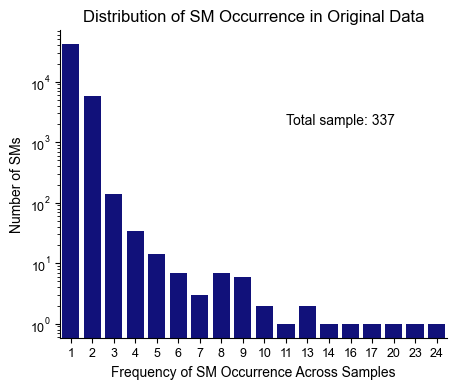

In [ ]:
# ------ 统计 SM 的样本分布 ----------
# # 展示出现在一个样本的SM数量、出现在两个样本的SM数量、出现在三个样本的SM数量等
plt.figure(figsize=(5,4))
sns.barplot(x=dupSNP.index, y=dupSNP.values,color="darkblue")
plt.title("Distribution of SM Occurrence in Original Data", fontsize=12)
plt.xlabel("Frequency of SM Occurrence Across Samples", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.text(10, 2000, 'Total sample: 377', fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('nSM_diff_nsample.pdf',dpi=300)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'M', 'N', 'S', 'a', 'b', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 39, 48, 49, 54, 68, 69, 71, 72, 73, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90]
INFO:fontTools.subset:Closed glyph list over

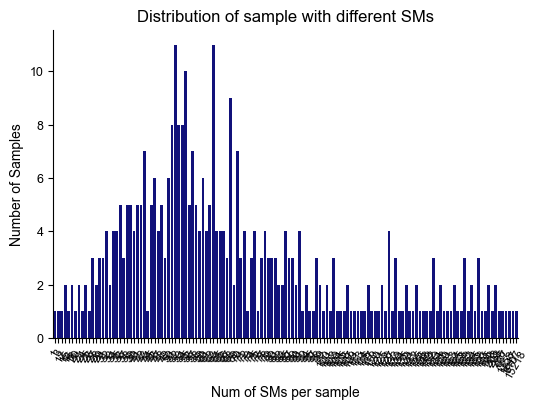

In [ ]:
# ---- 统计样本的分布 ----------
# 展示出现拥有一个SM的样本数量、拥有两个SM的样本数量、拥有三个SM的样本数量等

plt.figure(figsize=(6,4))
sns.barplot(x=dupSample.index, y=dupSample.values,color="darkblue")
plt.title("Distribution of sample with different SMs", fontsize=12)
plt.xlabel("Num of SMs per sample", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)
#plt.text(4, 2000, 'Total SMs: 9654', fontsize=10)
plt.xticks(fontsize=8,rotation=60)
plt.yticks(fontsize=9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('nsample_diff_nSMs.pdf',dpi=300,bbox_inches='tight')

## Overlapped SM
* Overlapped 的 SM 的数量与没有 overlapped 的 SM  

* 每个 Sample 中的 Overlapped SM 的比例

* SM 与 loop 的交集频率(与一个loop交集的SM有几个，与两个loop交集的SM有几个)

* overlapped SM 在样本中出现频次的分布（出现在一个样本的SM有几，出现两个样本的SMs有几个） 

* 样本中的 overlapped SM 数量的频次分布（含有一个SM的样本有几个，含有两个SM的样本有几个）   

In [8]:
# parirtobed 处理的数据 仅 overlap loop 的文件
# SM_loop=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation_tcga/SM_loop_1k.bedpe',sep='\t',header=None)
# SM_loop.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index']


SM_loop_gene=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation_tcga/SM_loop_1k_tss_all.bedpe',sep='\t',header=None)
SM_loop_gene.drop(columns=[11, 12, 13, 15, 16], inplace=True)
SM_loop_gene.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index','ENSG','symbol','genetype']


# SM_loop_or=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop.bedpe',sep='\t',header=None)
# SM_loop_or.columns=['loopid','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index']

/tmp/ipykernel_79690/2999171876.py:6: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  SM_loop_gene=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation_tcga/SM_loop_1k_tss_all.bedpe',sep='\t',header=None)


In [9]:
# 有 loop gene 的数据
# 合并 int 转变为 float，因为数据中有 NA
SNP_loop_s=pd.merge(SM_loop_gene,SNP,on='index',how='outer')
SNP_loop_ss=SNP_loop_s.loc[:,['index','hg38id','Variant_Classification','Hugo_Symbol','Tumor_Sample_Barcode','dbSNP_RS','Variant_Type','chr1','start1','end1','chr2','start2','end2','chr','start','end','ENSG','symbol','genetype']]

SNP_loop_ss['loopid'] = np.where(
    SNP_loop_ss[['chr1','start1', 'end1', 'chr2', 'start2', 'end2']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA
    SNP_loop_ss['chr1'] + '_' + 
    (((SNP_loop_ss['start1'] + SNP_loop_ss['end1']) / 2).fillna(0).astype(int).astype(str)) + '_' +  # 计算中点，转换为 int 再转换为 str
    SNP_loop_ss['chr2'] + '_' + 
    (((SNP_loop_ss['start2'] + SNP_loop_ss['end2']) / 2).fillna(0).astype(int).astype(str))  # 同样处理
)


In [10]:
print(f'Num of indexed loopid hg38id and Patient pair is {SNP_loop_ss.loc[SNP_loop_ss['loopid'].notna(),['loopid','hg38id','Tumor_Sample_Barcode','index']].drop_duplicates().shape}') # 51214 共54870 41729
print(f'Num of deduplicated loopid hg38id and Patient pair is {SNP_loop_ss.loc[SNP_loop_ss['loopid'].notna(),['loopid','hg38id','Tumor_Sample_Barcode']].drop_duplicates().shape}') # 51214 共54870 41729
print(f'Num of all loopid hg38id gene and Patient pair is {SNP_loop_ss.loc[SNP_loop_ss['loopid'].notna(),['loopid','hg38id','Tumor_Sample_Barcode']].shape}') # 51214 共54870 41729

print(f'Num of Patient-SM pairs is {SNP_loop_ss['index'].nunique()}') # 54870
print(f'Num of Overlapped Patient-SM pairs is {SNP_loop_ss.loc[~SNP_loop_ss['loopid'].isna(),'index'].nunique()}') # 13141


print(f'Num of Overlapped SM is {SNP_loop_ss.loc[~SNP_loop_ss['loopid'].isna(),'hg38id'].nunique()}') # 11635
print(f'Num of non-overlapped SM is {SNP_loop_ss.loc[SNP_loop_ss['loopid'].isna(),'hg38id'].nunique()}') # 36767
print(f'Num of SM is {SNP_loop_ss.loc[:,'hg38id'].nunique()}') # 36767

Num of indexed loopid hg38id and Patient pair is (27534, 4)
Num of deduplicated loopid hg38id and Patient pair is (25029, 3)
Num of all loopid hg38id gene and Patient pair is (75394, 3)
Num of Patient-SM pairs is 54870
Num of Overlapped Patient-SM pairs is 13141
Num of Overlapped SM is 11635
Num of non-overlapped SM is 36767
Num of SM is 48402


In [ ]:
# 找到了 重复原因 是有些hg38id在一个样本中出现了两次，t_ref_count和t_alt_count不同。
SNP.loc[SNP.duplicated(subset=['Tumor_Sample_Barcode','hg38id','Hugo_Symbol'], keep=False),['Mutation_Status', 'Sequencing_Phase',
       'Sequence_Source', 'Validation_Method', 'Score', 'BAM_File',
       'Sequencer', 't_ref_count', 't_alt_count', 'n_ref_count', 'n_alt_count','Hugo_Symbol']]


,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,t_ref_count,t_alt_count,n_ref_count,n_alt_count,Hugo_Symbol
295,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,33,12,NaN,NaN,NKAIN1
296,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,15,6,NaN,NaN,NKAIN1
299,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,64,22,NaN,NaN,KCNA2
300,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,62,34,NaN,NaN,KCNA2
303,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,254,71,NaN,NaN,RYR2
...,...,...,...,...,...,...,...,...,...,...,...,...
52306,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,292,18,NaN,NaN,DPP6
52308,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,121,18,NaN,NaN,MORN5
52309,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,122,15,NaN,NaN,MORN5
52310,Somatic,NaN,NaN,NaN,NaN,NaN,NaN,37,8,NaN,NaN,SLITRK4


#### 检测 Hugo Symbol 和 hg38id 的位置关系

In [95]:
# 看一下 SM 文件里的 Hugo_Symbol 列作用
SNP_loop_ssg=pd.merge(SNP_loop_ss,genebed,left_on='Hugo_Symbol',right_on='symbol',how='left')
SNP_loop_ssg.loc[:,'inGene']=np.where(
    SNP_loop_ssg[['chr_y', 'start_y', 'end_y', 'symbol_y']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA  发现有些基因没有匹配的位置信息
    np.where(
        (SNP_loop_ssg['start_x']>=SNP_loop_ssg['start_y']) & (SNP_loop_ssg['end_x']<=SNP_loop_ssg['end_y']),
        1,
        0
    )
)

In [96]:
# 发现 x1 x2 不一样
x1=SNP_loop_ssg[['hg38id','Hugo_Symbol','inGene']].drop_duplicates()
x2=SNP_loop_ssg[['hg38id','Hugo_Symbol']].drop_duplicates()
x2=x2.reindex(x1.index,fill_value=0)
x2.compare(x1.iloc[:,[0,1]]) # 发现有些基因有两个位置信息，所以有两个 inGene 信息

Empty DataFrame
Columns: []
Index: []

In [97]:
# hg19和Hugo_Symbol的对应关系
SNP_loop_ssgs=SNP_loop_ssg.loc[:,['hg38id','inGene','Hugo_Symbol','chr_x','start_x','end_x','chr_y','start_y','end_y']].drop_duplicates()
print(f'Num of genes correspond to hg38id is {SNP_loop_ssgs['inGene'].value_counts().sum()}') #48276总共hg19id 6325个对应的Huget_Symbol是有注释
print(f'Non-match gene num is {SNP_loop_ssgs['inGene'].isna().sum()}') #126个没有匹配到基因的hg19id
print(f'Result of match gene is {SNP_loop_ssgs["inGene"].value_counts()}') # 有6325个hg19id对应的基因有注释，209个没有匹配到基因的hg19id

Num of genes correspond to hg38id is 48276
Non-match gene num is 126
Result of match gene is inGene
1.0    47979
0.0      297
Name: count, dtype: int64


In [98]:
# 看看不在基因内的 hg19id 和 Hugo_Symbol 是什么关系
SNP_loop_ssgs[SNP_loop_ssgs.loc[:,'inGene']==0.0]

,hg38id,inGene,Hugo_Symbol,chr_x,start_x,end_x,chr_y,start_y,end_y
12,chr14_23389500_23389500,0.0,MIR208A,chr14,23389499,23389500,chr14,23388595.0,23388666.0
649,chr10_21172392_21172392,0.0,NEBL-AS1,chr10,21172391,21172392,chr10,21174013.0,21175048.0
827,chr6_33406294_33406294,0.0,PHF1,chr6,33406293,33406294,chr6,33410398.0,33416453.0
1200,chr19_54279836_54279836,0.0,MIR4752,chr19,54279835,54279836,chr19,54282108.0,54282180.0
2376,chr19_8731393_8731393,0.0,RPL23AP78,chr19,8731392,8731393,chr19,8728734.0,8729204.0
...,...,...,...,...,...,...,...,...,...
123549,chr2_218827017_218827017,0.0,MIR9500,chr2,218827016,218827017,chr2,218823089.0,218823154.0
124028,chrX_155939775_155939775,0.0,VAMP7,chrX,155939774,155939775,chrY,57067864.0,57130289.0
124384,chr19_51006508_51006508,0.0,KLK8,chr19,51006507,51006508,chr19,50996006.0,51002711.0
124473,chr7_93479425_93479425,0.0,MIR489,chr7,93479424,93479425,chr7,93483935.0,93484019.0


In [100]:
# 看不在基因内的SM与Hugo_Symbol的关系
# 使用 pd.notnull() 确保参与计算的列没有NA值
mask = (SNP_loop_ssgs['inGene'] == 0) & pd.notnull(SNP_loop_ssgs['end_x']) & pd.notnull(SNP_loop_ssgs['start_y']) & pd.notnull(SNP_loop_ssgs['start_x']) & pd.notnull(SNP_loop_ssgs['end_y'])

SNP_loop_ssgs.loc[mask, 'distance'] = np.where(
    SNP_loop_ssgs.loc[mask, 'end_x'] < SNP_loop_ssgs.loc[mask, 'start_y'],
    SNP_loop_ssgs.loc[mask, 'start_y'] - SNP_loop_ssgs.loc[mask, 'end_x'],
    SNP_loop_ssgs.loc[mask, 'start_x'] - SNP_loop_ssgs.loc[mask, 'end_y']
)

In [ ]:
# 发现了bug原因，一个symbol对应多个位置信息，genebed只保留了第一个
SNP_loop_ssgs.loc[((SNP_loop_ssgs['chr_x'] != SNP_loop_ssgs['chr_y']) & (SNP_loop_ssgs['chr_y'].notna())),:].sort_values('distance', ascending=False)

,hg38id,inGene,Hugo_Symbol,chr_x,start_x,end_x,chr_y,start_y,end_y,distance
60082,chr2_231455876_231455876,0.0,SNORA75,chr2,231455875,231455876,chr16,23441840.0,23441921.0,208013954.0
53495,chrX_154400307_154400307,0.0,SNORA70,chrX,154400306,154400307,chr14,51244089.0,51244224.0,103156082.0
102189,chrX_156010132_156010132,0.0,IL9R,chrX,156010131,156010132,chrY,57184215.0,57197337.0,98812794.0
124028,chrX_155939775_155939775,0.0,VAMP7,chrX,155939774,155939775,chrY,57067864.0,57130289.0,98809485.0
74017,chrX_156001429_156001429,0.0,IL9R,chrX,156001428,156001429,chrY,57184215.0,57197337.0,98804091.0
70150,chrX_155919868_155919868,0.0,VAMP7,chrX,155919867,155919868,chrY,57067864.0,57130289.0,98789578.0
69957,chrX_155900530_155900530,0.0,VAMP7,chrX,155900529,155900530,chrY,57067864.0,57130289.0,98770240.0
82128,chr9_64411759_64411759,0.0,ANKRD20A5P,chr9,64411758,64411759,chr18,14179394.0,14244811.0,50166947.0


In [102]:
SNP_loop_ssgs['distance'].describe().apply(lambda x: f'{x:.2f}')

count          297.00
mean       2882582.05
std       18632680.37
min         -10932.00
25%           1343.00
50%           2743.00
75%           4008.00
max      208013954.00
Name: distance, dtype: object

### 统计 overlapped SM 

In [14]:
SNP_loop_ss.loc[:,'score']=[1 if pd.notna(i) else 0 for i in SNP_loop_ss['loopid']] #chr1指示是否为loop

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 33 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'L', 'M', 'O', 'P', 'S', 'a', 'e', 'f', 'four', 'g', 'h', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'percent', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'v', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 21, 23, 25, 26, 38, 47, 48, 50, 51, 54, 68, 72, 73, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88, 89, 90]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 33 glyphs after

非零值的个数: 11635
零值的个数: 36767


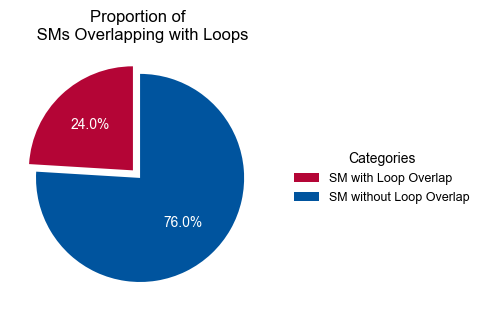

In [129]:
# Overlapped SM num VS Non-overlapped SM num

nonzero_count = (SNP_loop_ss.groupby('hg38id')['loopid'].count() > 0).sum() #6534
print("非零值的个数:", nonzero_count) #11635
zero_count = (SNP_loop_ss.groupby('hg38id')['loopid'].count() == 0).sum() # 6534-3660=2874
print("零值的个数:", zero_count) #11635
# 数据
labels = ['SM with Loop Overlap', 'SM without Loop Overlap']
sizes = [nonzero_count, zero_count]  # 各类别的数量
colors = ['#B40536','#00549E' ]  # 饼图的颜色
explode = (0.1, 0)  # 突出显示第一个类别

# 绘制饼图
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,textprops={'color': 'white'})
plt.title('Proportion of \n SMs Overlapping with Loops', fontsize=12)
plt.legend(labels, loc='center left',bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False, title="Categories", title_fontsize=10)
plt.tight_layout()
plt.savefig('SM_loop_overlap.pdf',dpi=300,bbox_inches='tight')

In [111]:
# SNP与loop交集的的频率 的分布（重叠1个loop的有多少个,重叠2次的有多少个，分开考虑不同样本的SNP）

nloopSM=SNP_loop_ss.groupby('hg38id')['loopid'].count().value_counts() #chr1 是 loop 的坐标，NA 表示没有loop

In [109]:
# 看一下很多loop的SNP是什么样的
SNP_loop_ss.groupby('hg38id')['loopid'].count().sort_values(ascending=False)

hg38id
chr2_208248388_208248388     391
chr1_154966413_154966414     184
chr7_27198291_27198291       145
chr7_27199317_27199317       145
chr17_10652518_10652519      135
                            ... 
chr10_100978319_100978319      0
chr10_100980193_100980193      0
chr10_100988404_100988404      0
chr10_100479904_100479904      0
chr10_100488924_100488924      0
Name: loopid, Length: 48402, dtype: int64

In [110]:
# 详细的信息
SNP_loop_ss.loc[SNP_loop_ss['hg38id']=='chr2_208248388_208248388',:]

,index,hg38id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,...,start2,end2,chr,start,end,ENSG,symbol,genetype,loopid,score
989,475,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-02-2483-01A,rs121913500,SNP,chr2,207730000.0,207760000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000272851.1,ENSG00000272851,lncRNA,chr2_207745000_chr2_208255000,1
990,475,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-02-2483-01A,rs121913500,SNP,chr2,207730000.0,207760000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000284079.1,MIR4775,miRNA,chr2_207745000_chr2_208255000,1
991,475,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-02-2483-01A,rs121913500,SNP,chr2,207730000.0,207760000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000231908.2,IDH1-AS1,lncRNA,chr2_207745000_chr2_208255000,1
992,475,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-02-2483-01A,rs121913500,SNP,chr2,207730000.0,207760000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000138413.14,IDH1,protein_coding,chr2_207745000_chr2_208255000,1
993,475,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-02-2483-01A,rs121913500,SNP,chr2,207730000.0,207760000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000115020.17,PIKFYVE,protein_coding,chr2_207745000_chr2_208255000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118611,51486,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-32-4208-01A,rs121913500,SNP,chr2,208160000.0,208190000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000168582.5,CRYGA,protein_coding,chr2_208175000_chr2_208255000,1
118612,51486,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-32-4208-01A,rs121913500,SNP,chr2,208160000.0,208190000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000231908.2,IDH1-AS1,lncRNA,chr2_208175000_chr2_208255000,1
118613,51486,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-32-4208-01A,rs121913500,SNP,chr2,208160000.0,208190000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000138413.14,IDH1,protein_coding,chr2_208175000_chr2_208255000,1
118614,51486,chr2_208248388_208248388,Missense_Mutation,IDH1,TCGA-32-4208-01A,rs121913500,SNP,chr2,208160000.0,208190000.0,...,208240000.0,208270000.0,chr2,208248387,208248388,ENSG00000115020.17,PIKFYVE,protein_coding,chr2_208175000_chr2_208255000,1


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'E', 'F', 'L', 'M', 'N', 'O', 'S', 'a', 'b', 'c', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 39, 40, 41, 47, 48, 49, 50, 54, 68, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 

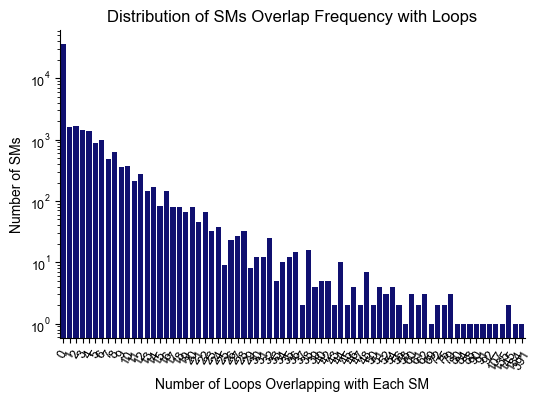

In [128]:

plt.figure(figsize=(6,4))
sns.barplot(x=nloopSM.index, y=nloopSM.values,color="navy")
plt.title("Distribution of SMs Overlap Frequency with Loops", fontsize=12)
plt.xlabel("Number of Loops Overlapping with Each SM", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9,rotation=60)
plt.yticks(fontsize=9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('nloop_perSM2.pdf',dpi=300,bbox_inches='tight')

In [117]:
# 统计每个 overlap SNP 在样本中出现的频率，然后统计这个频率的分布。即出现在一个样本的SNP有多少个，出现在两个样本的SNP有多少个

# loopscore=pd.crosstab(SNP_loop_simple_long['ID'], df_long['Variable'])
df_wide = SNP_loop_ss.pivot_table(index='Tumor_Sample_Barcode', columns='hg38id', values='score', aggfunc='sum') # 统计了每个样本中每个SNP出现的次数
df_wide.fillna(0, inplace=True)
snpsample=(df_wide>0).sum(axis=0).value_counts()#6534，大于0的个数（不是直接计算每列的和），再统计每列和的分布
snpsample1=SNP_loop_ss[SNP_loop_ss['score']!=0].groupby('hg38id')['Tumor_Sample_Barcode'].nunique().value_counts()#6534，只能先筛选出有loop的数据，然后再统计每列和的分布，这样会丢弃掉没有loop的样本
snpsample,snpsample1

(0     36767
 1     11455
 2       153
 3         9
 4         5
 5         4
 8         2
 9         1
 6         1
 13        1
 21        1
 17        1
 7         1
 15        1
 Name: count, dtype: int64,
 Tumor_Sample_Barcode
 1     11455
 2       153
 3         9
 4         5
 5         4
 8         2
 9         1
 6         1
 13        1
 21        1
 17        1
 7         1
 15        1
 Name: count, dtype: int64)

In [118]:
snpsample1.sum(),snpsample.sum() # 3660, 6534,3723

(11635, 48402)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'L', 'M', 'N', 'O', 'S', 'a', 'b', 'c', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 39, 47, 48, 49, 50, 54, 68, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90]
INFO:fon

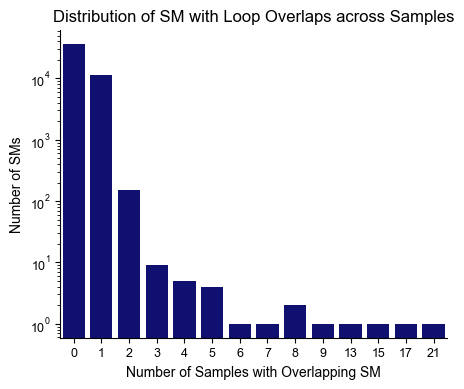

In [127]:
# 大部分的SNP只出现在一个样本中
plt.figure(figsize=(5,4))
sns.barplot(x=snpsample.index.astype(int), y=snpsample.values,color="navy")
plt.title("Distribution of SM with Loop Overlaps across Samples", fontsize=12)
plt.xlabel("Number of Samples with Overlapping SM", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('noverlapSM_diff_nsample.pdf',dpi=300,bbox_inches='tight')

In [124]:
# 统计拥有不同数量的SM的样本数量的分布，即多少样本有一个SM，多少样本有两个SM

samplesnp=(df_wide>0).sum(axis=1).value_counts().sort_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'M', 'N', 'O', 'S', 'a', 'b', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 39, 48, 49, 50, 54, 68, 69, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90]
INFO:fontTools.su

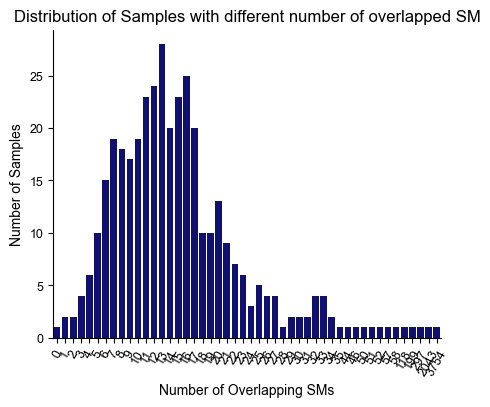

In [126]:
# 大部分样本都拥有overlapped SM

plt.figure(figsize=(5,4))
sns.barplot(x=samplesnp.index.astype(int), y=samplesnp.values,color="navy")
plt.title("Distribution of Samples with different number of overlapped SM", fontsize=12)
plt.xlabel("Number of Overlapping SMs", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)

plt.xticks(fontsize=9,rotation=60)
plt.yticks(fontsize=9)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('nsample_diff_noverlapSM.pdf',dpi=300,bbox_inches='tight')

In [24]:
# 每个样本 overlaped SM 和 non-overlaped SM 的数量比例

# dupSample=SNP['Tumor_Sample_Barcode'].value_counts() # 有几个样本有重复的SM 这种方法不对
# SNP.loc[SNP['Tumor_Sample_Barcode']=='C3L-01887','hg19id'].duplicated().sum() #1

# 正确数量的方法，去掉每个样本中duplicated的SM
dupSample=SNP.groupby('Tumor_Sample_Barcode')['hg38id'].nunique() 
all_persample=SNP_loop_ss.groupby('Tumor_Sample_Barcode')['hg38id'].nunique()
# all_persample_aligned=all_persample.reindex(dupSample.index,fill_value=0) # 比较两种方法的结果
# all_persample_aligned.compare(dupSample,align_axis=0)

# 统计有score的SM的样本中，每个样本中有多少个SM
overlap_persample=SNP_loop_ss[SNP_loop_ss['score']>0].groupby('Tumor_Sample_Barcode')['hg38id'].nunique().reindex(all_persample.index,fill_value=0)

overlap_ratio=overlap_persample/all_persample
overlap_ratio=overlap_ratio.sort_values(ascending=False)

/tmp/ipykernel_87499/1777233898.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overlap_ratio.index, y=overlap_ratio.values,palette=colors,edgecolor='black',linewidth=0.2)
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'I', 'J', 'K', 'L', 'M', 'O', 'R', 'S', 'T', 'U', 'W', 'X', 'a', 'c', 'd', 'e', 

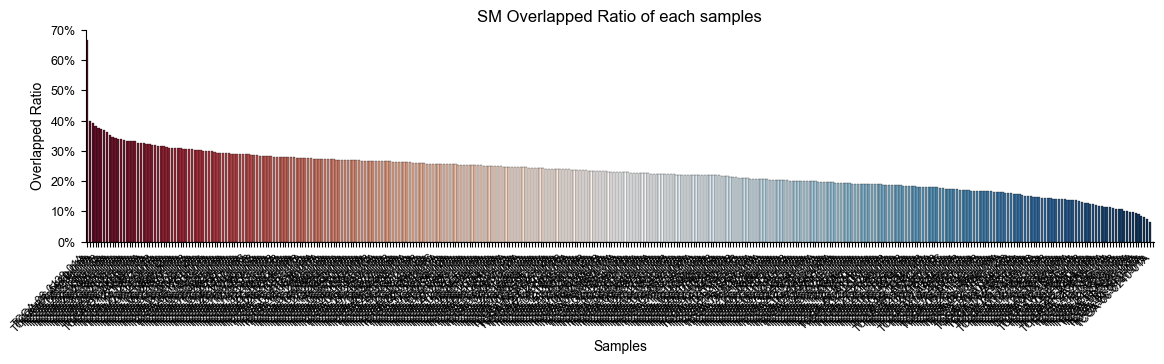

In [134]:
# 统计每个样本大概有多少处于loop中的SM
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#16365F","#77A3BB","#F8F2ED","#D64F38"])
# colors = [custom_cmap(i / (len(overlap_ratio) - 1)) for i in range(len(overlap_ratio))]
colors = [plt.cm.RdBu(i / (len(overlap_ratio) - 1)) for i in range(len(overlap_ratio))]


plt.figure(figsize=(12,4))
sns.barplot(x=overlap_ratio.index, y=overlap_ratio.values,palette=colors,edgecolor='black',linewidth=0.2)



plt.title("SM Overlapped Ratio of each samples", fontsize=12)
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Overlapped Ratio", fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.xticks(ticks=range(len(overlap_ratio)), labels=overlap_ratio.index, fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=9)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout(pad=2.0)  
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('ploop_persample.pdf',dpi=300,bbox_inches='tight')


## 获取 SM 附近的Hi-C contact，添加为score  

* 用raw contact 完全不行


In [ ]:

SNP_loop_ss=SNP_loop_ss.loc[:,['index','hg38id','loopid','Tumor_Sample_Barcode','ENSG','symbol','genetype','chr1','start1','end1','chr2','start2','end2','chr','start','end']]
SNP_loop_ss=SNP_loop_ss.fillna(np.nan)
SNP_loop_ss[SNP_loop_ss.select_dtypes(include=['float64']).columns] = SNP_loop_ss.select_dtypes(include=['float64']).astype('Int64')
SNP_loop_ss.apply(lambda x: type(x[0]))

index                                   <class 'numpy.int64'>
hg38id                                          <class 'str'>
loopid                                        <class 'float'>
Tumor_Sample_Barcode                            <class 'str'>
ENSG                                            <class 'str'>
symbol                                          <class 'str'>
genetype                                        <class 'str'>
chr1                                          <class 'float'>
start1                  <class 'pandas._libs.missing.NAType'>
end1                    <class 'pandas._libs.missing.NAType'>
chr2                                          <class 'float'>
start2                  <class 'pandas._libs.missing.NAType'>
end2                    <class 'pandas._libs.missing.NAType'>
chr                                             <class 'str'>
start                                   <class 'numpy.int64'>
end                                     <class 'numpy.int64'>
dtype: o

In [ ]:
GBM=cooler.Cooler("/cluster/home/futing/Project/GBM/HiC/02data/03cool/10000/GBM_10000.cool")
A172=cooler.Cooler("/cluster/home/futing/Project/GBM/HiC/02data/03cool/10000/A172_10000.cool")


In [ ]:
# GBM_pixels=GBM.pixels(join=True)[:].iloc[:100,:]
# GBM.matrix(balance=True)[:]
# 读不了

In [ ]:
A172_bins=A172.bins()[:]
A172_pixels=A172.pixels(join=True)[:]
A172_bins.shape,A172_pixels.shape

((308837, 4), (49031319, 7))

In [ ]:
def get_binid(chr1,start1,end1,chr2,start2,end2,bins=A172_bins):
    startmid1=(start1+end1)//2
    startmid2=(start2+end2)//2
    bin1=bins[(bins['chrom']==chr1) & (bins['start']<=startmid1) & (bins['end']>=startmid1)]
    bin2=bins[(bins['chrom']==chr2) & (bins['start']<=startmid2) & (bins['end']>=startmid2)]
    if bin1.empty or bin2.empty:
        return None, None  # 如果找不到匹配的bin，返回None
    return bin1.index[0],bin2.index[0]

In [ ]:
A172_bins.head()
bins=A172_bins
chr1='chr1'
start1=33480000	
end1=33510000
chr2='chr1'
start2=34750000
end2=34780000
get_binid(chr1,start1,end1,chr2,start2,end2)

In [ ]:
# 为每个loop找到对应的bin
SNP_loop_ss.loc[SNP_loop_ss['loopid'].notna(),'bin1'], SNP_loop_ss.loc[SNP_loop_ss['loopid'].notna(),'bin2'] = zip(*SNP_loop_ss.loc[SNP_loop_ss['loopid'].notna(),:].apply(
    lambda x: get_binid(x['chr1'], x['start1'], x['end1'], x['chr2'], x['start2'], x['end2']), axis=1))


In [ ]:
# 看看pixels和matrix的关系
A172_pixels.loc[(A172_pixels['chrom1']=='chr1') & (A172_pixels['start1'] ==33490000) & (A172_pixels['start2'] == 34760000),:].head()

,chrom1,start1,end1,chrom2,start2,end2,count
383466,chr1,33490000,33500000,chr1,34760000,34770000,1


In [ ]:
A172.matrix(balance=True).fetch('chr1:33490000-33500000','chr1:34760000-34770000')

array([[0.00318418]])

In [ ]:
#308837
from joblib import Parallel, delayed

def fetch_contacts(row):
    matrix = GBM.matrix(balance=True).fetch(
        f'{row["chr1"]}:{row["start1"]+10000}-{row["end1"]-10000}',
        f'{row["chr2"]}:{row["start2"]+10000}-{row["end2"]-10000}'
    )
    if matrix.size == 1:
        return matrix.item()  # 返回标量值
    elif matrix.size == 0:
        return None  # 空数组返回 None
    else:
        print(f'Warning: {row["loopid"]} has more than one value')
        return matrix.mean()  


In [ ]:
SNP_loop_ss.head()

,index,hg38id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr,start,end,rawcontact,inGene
0,2,chr1_154176176_154176176,NaN,TCGA-02-0003-01A,ENSG00000143549.22,TPM3,protein_coding,NaN,<NA>,<NA>,NaN,<NA>,<NA>,chr1,154176175,154176176,NaN,1.0
1,3,chr10_122050517_122050517,NaN,TCGA-02-0003-01A,ENSG00000138162.19,TACC2,protein_coding,NaN,<NA>,<NA>,NaN,<NA>,<NA>,chr10,122050516,122050517,NaN,1.0
2,4,chr10_132153945_132153945,NaN,TCGA-02-0003-01A,ENSG00000188385.13,JAKMIP3,protein_coding,NaN,<NA>,<NA>,NaN,<NA>,<NA>,chr10,132153944,132153945,NaN,1.0
3,5,chr11_90135669_90135669,NaN,TCGA-02-0003-01A,ENSG00000077616.11,NAALAD2,protein_coding,NaN,<NA>,<NA>,NaN,<NA>,<NA>,chr11,90135668,90135669,NaN,1.0
4,6,chr11_124619643_124619643,NaN,TCGA-02-0003-01A,ENSG00000154143.3,PANX3,protein_coding,NaN,<NA>,<NA>,NaN,<NA>,<NA>,chr11,124619642,124619643,NaN,1.0


In [ ]:
notna_indices = SNP_loop_ss['loopid'].notna()
SNP_loop_ss.loc[notna_indices, 'contact'] = Parallel(n_jobs=-1)(
    delayed(fetch_contacts)(row) for _, row in SNP_loop_ss.loc[notna_indices].iterrows()
)



In [4]:
# SNP_loop_ss.to_csv('SNP_loop_ss.txt',index=False,sep='\t')
SNP_loop_ss=pd.read_csv('SNP_loop_ss.txt',sep='\t')

In [7]:
SNP_loop_ss.columns

Index(['index', 'hg38id', 'loopid', 'Tumor_Sample_Barcode', 'ENSG', 'symbol',
       'genetype', 'chr1', 'start1', 'end1', 'chr2', 'start2', 'end2', 'chr',
       'start', 'end', 'rawcontact', 'inGene', 'contact'],
      dtype='object')

## loop Coverage

In [69]:
coverage=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation_tcga/loop_coverage.txt',sep='\t',header=None)
hg38=pd.read_csv('/cluster/home/futing/ref_genome/hg38.genome',sep='\t',header=None)
hg38.columns=['chr','length']
coverage.columns=['chr','length','num']
# hg38=hg38.loc[~hg38['chr'].str.contains('chrY'),:]

In [70]:
coverage.shape,hg38.shape

((24, 3), (24, 2))

In [71]:
coverage=coverage.loc[coverage['chr'].isin(hg38['chr']),:]
hg38=hg38.set_index('chr')
coverage=coverage.set_index('chr').reindex(hg38.index,fill_value=0).reset_index()

In [80]:
coverage=pd.merge(hg38,coverage,on='chr',how='left')
coverage['ratio']=coverage['length_y']/coverage['length_x']

In [81]:
coverage=coverage.sort_values('ratio',ascending=False)

In [82]:
coverage.head()

,chr,length,length_x,length_y,num,ratio
16,chr17,83257441,83257441,13210000,382,0.158664
18,chr19,58617616,58617616,9240000,263,0.157632
11,chr12,133275309,133275309,18000000,520,0.135059
19,chr20,64444167,64444167,8570000,249,0.132983
5,chr6,170805979,170805979,20730000,613,0.121366


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'L', 'O', 'R', 'X', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'percent', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 38, 47, 50, 53, 59, 60, 68, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89]
INFO:fontTools.subset

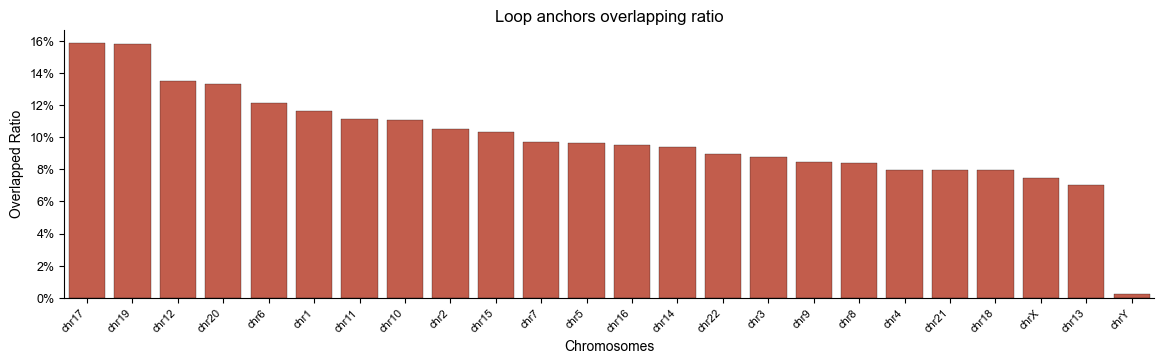

In [87]:
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#16365F","#77A3BB","#F8F2ED","#D64F38"])
colors = [custom_cmap(i / (len(coverage) - 1)) for i in range(len(coverage))]
# colors = [plt.cm.RdBu(i / (len(coverage) - 1)) for i in range(len(coverage))]


plt.figure(figsize=(12,4))
sns.barplot(x=coverage['chr'], y=coverage['ratio'],color="#D64F38",edgecolor='black',linewidth=0.2)
#palette=colors


plt.title("Loop anchors overlapping ratio", fontsize=12)
plt.xlabel("Chromosomes", fontsize=10)
plt.ylabel("Overlapped Ratio", fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.xticks(ticks=range(len(coverage)), labels=coverage['chr'], fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=9)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout(pad=2.0)  
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('Chr_ratio.pdf',dpi=300,bbox_inches='tight')

## Loop 

In [104]:
loop=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/GBMfil_merged.bed',sep='\t')

In [ ]:
loop.head()

,chr,start,end,P455.SF11901,P475.SF12180,P498.SF12251,P503.SF12518,P519.SF12601,P521.SF12631,P524.SF12681v1,...,U343,U87,G523,G567,G583,U251,H4,42MGBA,num,NonNA_Count
0,chr1,775000,855000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,chr1,785000,224045000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,15
2,chr1,825000,224015000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,chr1,895000,5665000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,chr1,905000,975000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,9


In [105]:
loop.columns

Index(['chr', 'start', 'end', 'P455.SF11901', 'P475.SF12180', 'P498.SF12251',
       'P503.SF12518', 'P519.SF12601', 'P521.SF12631', 'P524.SF12681v1',
       'P524.SF12681v4', 'P524.SF12681v9', 'P529.SF12794v1-1',
       'P529.SF12794v6-1', 'P529.SF12794v8-1', 'P530.SF12822v10',
       'P530.SF12822v13', 'P530.SF12822v14', 'P530.SF12822v15',
       'P530.SF12822v18', 'P530.SF12822v19', 'P530.SF12822v2',
       'P530.SF12822v4', 'P530.SF12822v5', 'G1', 'G23', 'G28', 'G61', 'G62',
       'G83', 'G120', 'G148', 'G163', 'G171', 'G181', 'G208', 'G213', 'G275',
       'G275R', 'G318', 'G323', 'G351', 'G390', 'G394', 'G402', 'G402R',
       'G412', 'G412R', 'G450', 'G452C', 'G452P', 'G457', 'A172', 'SW1088',
       'U118', 'U343', 'U87', 'G523', 'G567', 'G583', 'U251', 'H4', '42MGBA',
       'num', 'NonNA_Count'],
      dtype='object')

In [110]:
nloop=loop['NonNA_Count'].value_counts()
nloop.sum()

176605

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/tmp/ipykernel_10724/2897715124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nloop.index, y=nloop.values, palette="viridis")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


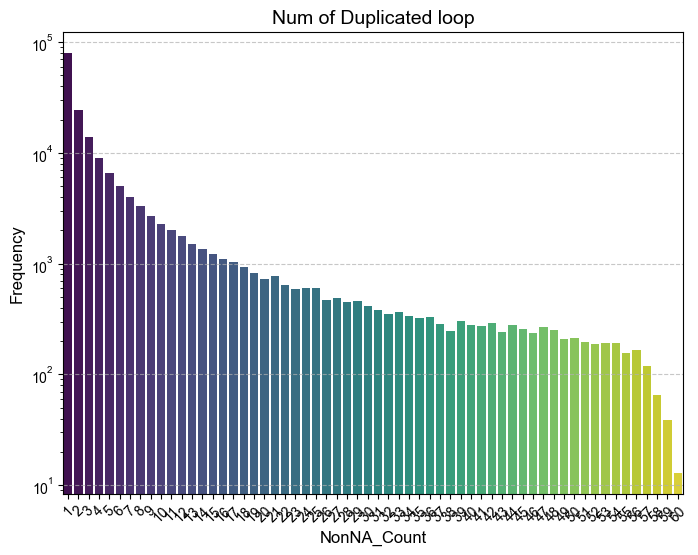

In [ ]:

plt.figure(figsize=(8, 6))
sns.barplot(x=nloop.index, y=nloop.values)
plt.title("Distribution of loops across samples", fontsize=14)
plt.xlabel("Num of samples a loop appears in", fontsize=12)
plt.ylabel("Num of samples", fontsize=12)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)